In [1]:
import sys
import os
import pandas as pd
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_dir)
from data_generator import normalize, normalize_new_data


In [7]:
#Full CSV Files
rainfall =pd.read_csv(r"..\data\final_data\rainfall.csv")
air_temperature = pd.read_csv(r"..\data\final_data\air_temperature.csv")
wind_speed = pd.read_csv(r"..\data\final_data\wind_speed.csv")
relative_humidity = pd.read_csv(r"..\data\final_data\relative_humidity.csv")
wind_direction = pd.read_csv(r"..\data\final_data\wind_direction.csv")
lightning_risk_16S = pd.read_csv(r"..\data\final_data\Lightning Risk 16S.csv") # Output
input_data_dfs = [rainfall, air_temperature, wind_speed, relative_humidity, wind_direction]
input_data_df_names = ["rainfall", "air_temperature", "wind_speed", "relative_humidity", "wind_direction"]

In [15]:
normalized_dfs = []
for i in range(len(input_data_dfs)):
    normalize(input_data_dfs[i], input_data_df_names[i])
    normalized_dfs.append(normalize_new_data(input_data_dfs[i], input_data_df_names[i]))

Zero Replace: 3.7037037037036997e-08
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 0.00021
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 4.27480916030534e-07
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 0.000321
Done saving scaler object and param dict.
Done normalizing
Zero Replace: 1e-05
Done saving scaler object and param dict.
Done normalizing


In [18]:
os.makedirs("../data/normalized_data/",exist_ok=True)

In [19]:
for i in range(len(input_data_df_names)):
    normalized_dfs[i].to_csv(os.path.join("../data/normalized_data/",input_data_df_names[i]+".csv"))

C:\Users\tomma\AppData\Local\Temp\ipykernel_28628\2262277832.py:30: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


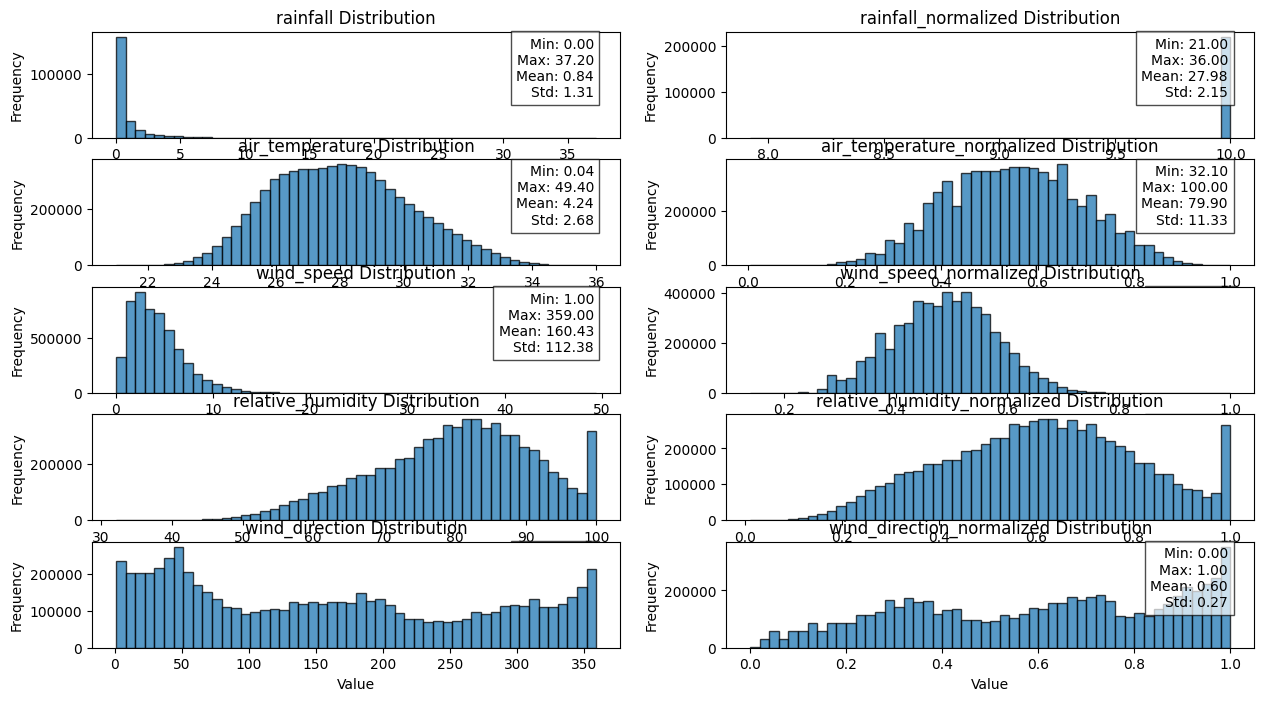

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 2x2 subplot layout
fig, axes = plt.subplots(5, 2, figsize=(20, 8))
axes = axes.flatten()  # Flatten for easy iteration

for i, (df, name) in enumerate(zip(input_data_dfs+normalized_dfs, input_data_df_names+[i+"_normalized" for i in input_data_df_names])):
    # Select only numerical columns (excluding Timestamp)
    df_values = df.drop(columns=["Timestamp"], errors="ignore").melt().value.dropna()
    df_values = df_values[df_values>0]
    # Convert to float
    df_values = df_values.astype(float)
    # Calculate statistics
    min_val = df_values.min()
    max_val = df_values.max()
    mean_val = df_values.mean()
    std_val = df_values.std()

    # Plot histogram
    axes[i*2 if i < 5 else (i-5)*2+1].hist(df_values, bins=50, alpha=0.75, edgecolor="black")
    axes[i*2 if i < 5 else (i-5)*2+1].set_title(f"{name} Distribution")
    axes[i*2 if i < 5 else (i-5)*2+1].set_xlabel("Value")
    axes[i*2 if i < 5 else (i-5)*2+1].set_ylabel("Frequency")
    stats_text = f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nMean: {mean_val:.2f}\nStd: {std_val:.2f}"
    axes[i*2 if i < 5 else (i-5)*2+1].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show()